In [25]:
# Here I test the CMIknn algorithm on the linear process (Process_1).
# CMIknn based on conditional mutual information 
# estimated with a k-nearest neighbor estimator. The statistical
# adopted also make uses of k-nearest neighbor.

# Import libraries and stuff
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [26]:
# Synthetic data definition: 
# 4 nodes (4 variables)
# time series are autocorrelated
# linear relationships

np.random.seed(1)
# data_t has 1010 data points. I then remove a transient of 10 points to define "data"
data_t = np.random.randn(1010, 4)

# process definition
for t in range(4, 1010):
    data_t[t, 0] += 0.8*data_t[t-1, 0]
    data_t[t, 1] += 0.4*data_t[t-1, 1] + 0.6*data_t[t-3, 2]*data_t[t-1, 3]
    data_t[t, 2] += 0.6*data_t[t-1, 2] + 0.9*data_t[t-1, 0]
    data_t[t, 3] += 0.5*data_t[t-1, 3] + 0.4*data_t[t-2, 0]

In [27]:
# remove the transient
data = data_t[10:]

In [28]:
T = len(data)     # time series length
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names)

Text(0.5, 1.0, 'x_3')

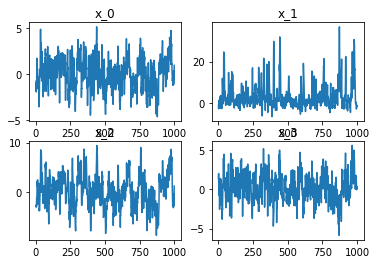

In [29]:
# Let's give a look to the 4 time series
timeSeries = np.transpose(data)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(timeSeries[0])
ax1.set_title('x_0')

ax2 = plt.subplot(2, 2, 2)
ax2.plot(timeSeries[1])
ax2.set_title('x_1')

ax3 = plt.subplot(2, 2, 3)
ax3.plot(timeSeries[2])
ax3.set_title('x_2')

ax4 = plt.subplot(2, 2, 4)
ax4.plot(timeSeries[3])
ax4.set_title('x_3') 

In [30]:
# CMIknn involves no assumptions about the dependencies. 
# The parameter knn determines the size of hypercubes, ie., 
# the (data-adaptive) local length-scale. 
# To compute the statistical significance we use 
# significance='shuffle_test' to generate it in each individual test. 
# The shuffle test for testing $I(X;Y|Z)=0$ shuffles $X$ values locally: 
# Each sample point $i$’s $x$-value is mapped randomly to one of 
# its nearest neigbors (shuffle_neighbors parameter) 
# in subspace $Z$. The following cell may take some minutes.

# Number of surrogates? 500
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5)
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)

In [ ]:
###################### STEP 1 ######################

# PC1 conditional indipendent testing for causal links 
# with lags up to \tau = 8 and significance at the 95%
results = pcmci_cmi_knn.run_pcmci(tau_max=8, pc_alpha=0.05)

# mci testing with alpha_level 0.01 (99% significance)
# Remember to (1) test this alpha level (try with 0.05 for example) and (2)
# add the FDR condition of Benjamini-Hochberg later to see the changes
pcmci_cmi_knn.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

In [ ]:
###################### STEP 2 ######################

# False Discovery Rate by Benjamini-Hochberg to control (on average) 
# the number of False Positives. I specify alpha_level = 0.01
# this means that on average I will only have 1% of False Positives.
q_matrix = pcmci_cmi_knn.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci_cmi_knn.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)